# Introduction to MapReduce

This tutorial will introduce you to MapReduce, a common programming model for generating and processing large data sets using a distributed algorithm. The primary advantage of MapReduce lies in its ability to use large sets of computers (nodes or clusters) to parallelize data computation and processing. The paradigm has a wide range of applications including in machine learning, image processing, statistical machine translation, and distributed file systems, among others. We will first explore a proverbial application of MapReduce to learn basics, and then dive into more complicated applications like document and k-means clustering.

Many companies and open source contributers have invested years in refining implementations of MapReduce including Apache Hadoop, Amazon Elastic, Python's Disco, and Google's MapReduce. These are complex frameworks aimed at running distributed jobs across many physical/virtual machines. To reduce complexity we will be using Mincemeat to run jobs on our local machines. It's a lightweight proof of concept implementation of the paradigm that runs locally. 

To get mincemeat setup, simply run the following command in the same folder as this notebook. 

```
    $ wget https://raw.githubusercontent.com/michaelfairley/mincemeatpy/v0.1.4/mincemeat.py
```

Please visit the [github](https://github.com/michaelfairley/mincemeatpy) if you need additional assistance setting up. Once that is setup, ensure the following works for you:

In [177]:
import requests
import mincemeat 
import re
import scipy as sp
import numpy as np
import matplotlib

matplotlib.use("svg")

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = (10.0, 5.0) # you should adjust this to fit your screen

/Users/aatishn/Documents/15388/env-15388/lib/python2.7/site-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


We will start with the proverbial MapReduce application of counting the frequency of alphabetic characters in a large piece of text. First we will write a couple lines of Python to retreive the text:


In [2]:
url = "https://en.wikipedia.org/wiki/MapReduce"
resp = requests.get(url)
data = resp.content.split("\n")


As the name suggests, the pipeline starts with the Map(). This step typically filters and transforms the data. In this example, we will take each line of input and make a tuple for each character. Thus, it will look like this: (char, 1)

In [3]:
def mapfn(key, line):
    for c in line.lower():
        # Only consider alphabet
        if 'a' <= c and c <= 'z':
            yield (c, 1)

Next, we will do Reduce(). This step typically performs a summary or aggregation operation. In this example, it will sum up all the occurences of the same character, yielding one count for each character. 

In [ ]:
def reducefn(key, counts):
    return sum(counts)

Now that we have both function, we can run our MapReduce job and plot the results.

In [ ]:
# The data source can be any dictionary-like object
datasource = dict(enumerate(data))

s = mincemeat.Server()
s.datasource = data
s.mapfn = mapfn
s.reducefn = reducefn

results = s.run_server(password="changeme")
print results

You should get the following output:

```
{'a': 9283, 'c': 4384, 'b': 1435, 'e': 11102, 'd': 3649, 'g': 2856, 'f': 2789, 'i': 8886, 'h': 2647, 'k': 1514, 'j': 222, 'm': 2814, 'l': 6222, 'o': 6234, 'n': 5520, 'q': 90, 'p': 4008, 's': 6009, 'r': 6214, 'u': 2412, 't': 8258, 'w': 1832, 'v': 915, 'y': 913, 'x': 635, 'z': 188}
```

This by itself does not make that much sense to a data scientist. Let's plot the frequencies and see if we can see something interesting. 

/Users/aatishn/Documents/15388/env-15388/lib/python2.7/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


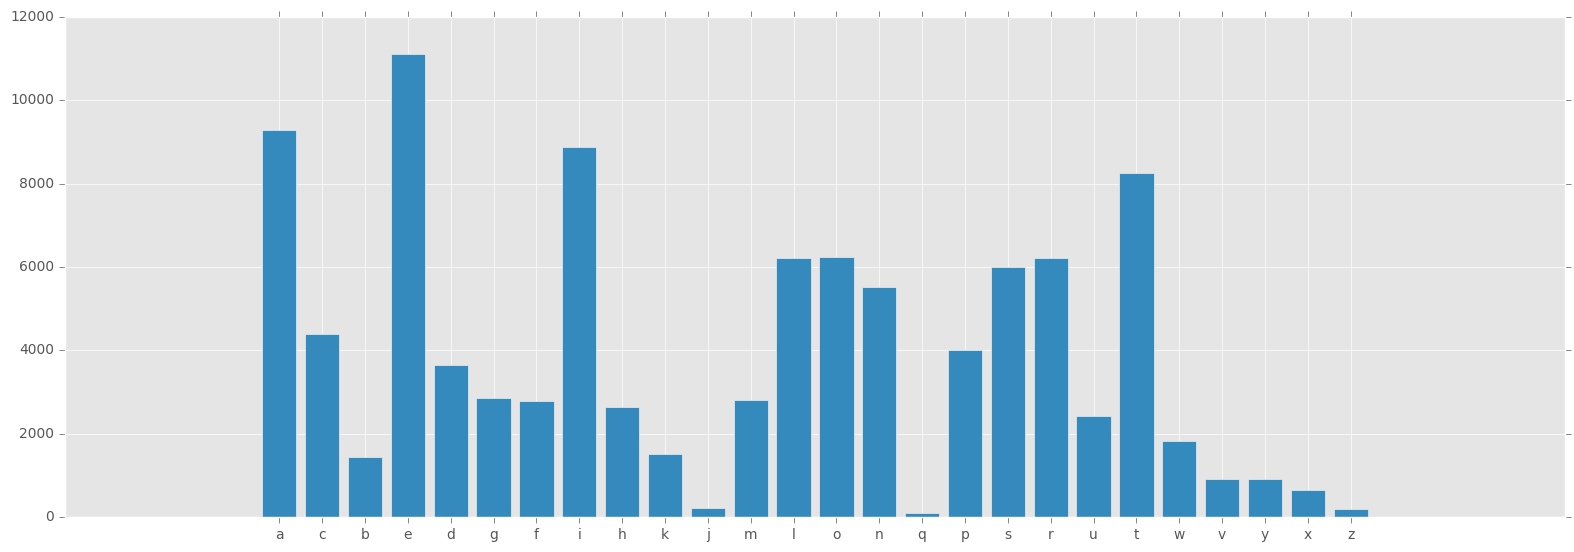

In [4]:
xs, ys = results.keys(), results.values()
x = sp.arange(len(xs))
y = sp.array(ys)
f = plt.figure()
ax = f.add_axes([0,0,1.5,1])
ax.bar(x, y, align="center")
ax.set_xticks(x)
ax.set_xticklabels(xs)
f.show()

As you can see, the graph shows the most popular letters are a, e, and t. In general, these are some of the most common letters in the English language. This is a very trivial application of MapReduce, however it illustrates the pipeline. The following figure shows the transfer of data and what the whole process looks like. We'll cover more complicated examples in the next section. 


![MapReduce Image](mapreduceimage.gif)


# Document Clustering with MapReduce

Document clustering is the application of cluster analysis to group documents together. It has various applications in search engines, fast information retreival, and automatic document organization, among others. The process typically involves the following steps: tokenization, stemming, removing stop words and punctuation, clustering, and evaluation. The premise of clustering involves the use and determination of a unique descriptor. A descriptor is a set of parsed works that describe the contents of each cluster. Text with relative distances (discussed below) within a certain range are put into the same bucket or cluster.

In this example, we will be analyzing grouping a text of athletic product titles:

```
Converse All Star PC2 - Boys' Toddler
Converse All Star PC2 - Girls' Toddler
HI Nike Sport Girls Golf Dress
Brooks Nightlife Infiniti 1/2 Zip - Women's
HI Nike Solid Girls Golf Shorts
Nike Therma-FIT K.O. (MLB Rays)
adidas adiPURE IV TRX FG - Men's
Nike College All-Purpose Seasonal Graphic (Oklahoma) Womens T-Shirt
adidas Adipure 11PRO TRX FG - Women's
HI Nike Team (NFL Giants) BCA Womens T-Shirt
adidas Sprintstar 4 - Men's
HI Nike Attitude (NFL Titans) BCA Womens T-Shirt
HI Nike Polo Girls Golf Dress
Nike Therma-FIT K.O. (MLB Twins)
adidas Sprintstar 3 - Women's
Under Armour Performance Team Polo - Mens - For All Sports - Clothing - Purple/White
Converse All Star Ox - Girls' Toddler
HI Nike College All-Purpose Seasonal Graphic (Washington) Womens T-Shirt
Under Armour Performance Team Polo - Mens - For All Sports - Clothing - Red/White
Nike Therma-FIT K.O. (MLB Phillies)
Brooks Nightlife Infiniti 1/2 Zip Jacket - Mens
HI Nike Attitude (NFL Titans) BCA Mens Pants
HI Nike College All-Purpose Seasonal Graphic (Virginia) Mens T-Shirt
HI Nike Team (NFL Steelers) BCA Mens T-Shirt
Nike College All-Purpose Seasonal Graphic (Virginia) Mens T-Shirt

```

First, we must contruct a unique descriptor or fingerprint for each title that will involve removing special chars, numbers, stop words (from NLTK), stemming each word, and sorting in alphbetical order. Stop words are usually universal words that do not provide additional information about the text (the, a, for, all, it, etc.). There is no universal list, however NLTK, a natural language processing library, has a fairly comprehensive list.

In [330]:
import string
import nltk
from stemming.porter2 import stem
 
class FingerPrint(object):
    def __init__(self):
        # Remove special characters 
        self.spec_char_regex = re.compile('[%s]' % re.escape(string.punctuation))
        # Regex for determining numbers
        self.nums_regex = re.compile('[\d]+')
        # All stop 
        self.stopwords = nltk.corpus.stopwords.words('english')
 
    def helper(self, text):
        text_lower = text.strip().lower()
        
        # Remove special characters and numbers
        spec_char_removed = self.spec_char_regex.sub(" ", text_lower)
        number_removed = self.nums_regex.sub("", spec_char_removed)
        words = number_removed.split()
        
        # Remove stop words
        filter_stop_words = [w for w in words if w not in self.stopwords]
        
        # Stem and sort 
        return sorted(map(stem, filter_stop_words))
     
    def fingerprint(self,text):
        fp = " ".join(self.helper(text))
        return fp

f = FingerPrint()

#### Important Change
The mapreduce framework we previously used, mincemeat, allows for only stateless computations. In other words, each key/value pair is considered independantly from others; this makes mapreduce perform really well in parallel. There's no way to track what we have computed previously. This proposes a challenge for document clustering which inherently has to consider relative distances between text. Thus, we will design our own stateful map and reduce functions, and pipe the output into each one. 

The map function will take each line and create a tuple of the line's fingerprint and the line itself with leading and trailing whitespace removed. The reduce function will use these two to determine the relative "distance" or similarity between two words.

In [54]:
def mapfn(key, line):
    return (f.fingerprint(line), line.strip())

The reduce function will take the mapped output and distribute each line into clusters. Relative distance between a two lines' descriptors will be determined using the Levenshtein distance i.e. the minimum number of single characters that need to change or be added/deleted to turn one string into the other. This is sometimes referred to as the minimum edit distance. 

For example, the Levenshtein distance between computer and consumer is 3: 

computer -> co**n**puter -> con**s**uter -> consu**m**er

We define a max default value of 20 for now. You can edit this value and see how it affects our clustering. 

In [331]:
from Levenshtein import distance as ldist
clusters = {}

# Change this and see what happens
MAX_DIST = 20

def reducefn(lines):
    clusters[0] = [lines[0]]
    i = 0
    for f, text in lines[1:]:
        prevf, _ = clusters[i][-1]
        
        if ldist(prevf, f) <= MAX_DIST:
            clusters[i].append((f, text))
        else:
            i += 1
            clusters[i] = [(f, text)]
    
    return clusters

In [100]:
# The data source can be any dictionary-like object
with open('doc-data.txt', 'rb') as fd:
    data = fd.readlines()
    data.sort()
    del fd

data = dict(enumerate(data))

# Map input
mapoutput = [mapfn(k, data[k].strip()) for k in data.keys()]

# Reduce map output
clusters = reducefn(mapoutput)

# Print output
for k in clusters.keys():
    print " "
    print "Cluster #"+str(k)
    for l in clusters[k]:
        print l[1]

You should see the following clustering results.


```
Cluster #0
Brooks Nightlife Infiniti 1/2 Zip - Women's
Brooks Nightlife Infiniti 1/2 Zip Jacket - Mens
 
Cluster #1
Converse All Star Ox - Girls' Toddler
Converse All Star PC2 - Boys' Toddler
Converse All Star PC2 - Girls' Toddler
 
Cluster #2
HI Nike Attitude (NFL Titans) BCA Mens Pants
HI Nike Attitude (NFL Titans) BCA Womens T-Shirt
 
Cluster #3
HI Nike College All-Purpose Seasonal Graphic (Virginia) Mens T-Shirt
HI Nike College All-Purpose Seasonal Graphic (Washington) Womens T-Shirt
 
Cluster #4
HI Nike Polo Girls Golf Dress
HI Nike Solid Girls Golf Shorts
HI Nike Sport Girls Golf Dress
 
Cluster #5
HI Nike Team (NFL Giants) BCA Womens T-Shirt
HI Nike Team (NFL Steelers) BCA Mens T-Shirt
 
Cluster #6
Nike College All-Purpose Seasonal Graphic (Oklahoma) Womens T-Shirt
Nike College All-Purpose Seasonal Graphic (Virginia) Mens T-Shirt
 
Cluster #7
Nike Therma-FIT K.O. (MLB Phillies)
Nike Therma-FIT K.O. (MLB Rays)
Nike Therma-FIT K.O. (MLB Twins)
 
Cluster #8
Under Armour Performance Team Polo - Mens - For All Sports - Clothing - Purple/White
Under Armour Performance Team Polo - Mens - For All Sports - Clothing - Red/White
 
Cluster #9
adidas Adipure 11PRO TRX FG - Women's
adidas Sprintstar 3 - Women's
adidas Sprintstar 4 - Men's
adidas adiPURE IV TRX FG - Men's
```

# Page Rank with MapReduce

PageRank is a very popular algorithm to rank nodes in a graph depending on how many edges it has. Since it's the basis for Google's search algorithm, it's most commonly used in search engines to rank website pages based on how many pages link to it. The basic premise is that each node's PageRank is determined by the contribution of its neighbor's PageRank. The neighbors also have to distribute their PageRank evenly amongst its neighbors. The following figure shows a sample graph. Notice that each node has a percentage that represents the fraction of the total PageRank that node gets. Typically, each node is first assigned a PageRank of 1 at the start of the algorithm. 

![image](https://upload.wikimedia.org/wikipedia/commons/thumb/f/fb/PageRanks-Example.svg/400px-PageRanks-Example.svg.png)

The PageRank of a node is represented by the following equation. ![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/9f853c33de82a94b16ff0ea7e7a7346620c0ea04)

**p<sub>i</sub>** is the ith page. **M(p<sub>i</sub>)** is the set of pages that link to **p<sub>i</sub>** (in-neighbors). **L(p<sub>j</sub>)** is the number of pages that link to **p<sub>j</sub>**. **N** is the total number of pages. We assume someone clicking through pages will click until they explore the whole graph. However, obviously this isn't a realistic assumption because no matter how much you procrastinate you can't explore the whole internet. Thus, **d** is the probability that someone will stop clicking, or damping factor. 

PageRank also is a great candidate for MapReduce because the summations and page ranks can be calculated in parallel. However, since we need access to precomputed info, we will not be using mincemeat. 

We will be ranking pages obtained from the Stanford Web Graph dataset from 2003. Even back then the internet was still massive, thus we will only be using 1000 nodes. It also includes a lot of information that we will not use in this example. However, we will also be using undirected graphs, thus outgoing and ingoing edges are equal for a node.

Ensure the following housekeeping lines compile. We will be using a damping factor of 0.85. Try to change it and see what happens to the results. 

In [329]:
from collections import namedtuple
Line = namedtuple('Line', 'node_num pr neighbors')
DELTA = 0.85 # damping factor

The map function takes in a key (the node number) and a Line tuple as defined above. It loops through all the neighbors, if they exist, and computes the current pagerank divided by the number of neighbors of the current node. This is what I referred to above as distributing a node's PageRank. It returns a list of all mapped neighbors. 

In [314]:
def map_pr(key, l):
    if len(l.neighbors) == 0:
        return [Line(l.node_num, l.pr, [])]
    out = []
    # Loop through all neighbors of current node
    for node in l.neighbors:
        # Divide current page rank by number of neighbors (L(pj) in equation)
        out.append(Line(node, l.pr / len(l.neighbors), []))
    return out

The reduce function gets the new PageRank by applying the above formula with the damping factor. It has access to a pre-computed ranks dictionary that we will discuss below. It returns the node number, the new PageRank, and the number of neighbors. We will use this data later to graph the results.

In [300]:
def reduce_pr(l):
    # Get new pagerank by multiplying current rank with alpha
    new_pr = (1 - DELTA) + DELTA * ranks[l.node_num]
    
    # Update page ranks
    return (l.node_num, new_pr, len(l.neighbors))


The `parse_line()` function parses the data from the text file. Most of it is self explanatory. The `run_map()` function loops through all parse lines, calls the map function on each one, and collects the results. 

In [312]:
def parse_line_map(line):
    l = line.strip().split("\t")
    
    key = l[0]
    value = l[1]
    
    # Get Node number
    node_num = int(''.join(x for x in key if x.isdigit()))
    
    # We can do multiple iterations so on the first one, add prefix with iteration num and rank
    if not value.startswith("i"):  
        value = "i0,r-1," + value   # On the first iteration we add an iteration marker and an initial rank
    value = value.split(",")
    
    # Extract iteration number
    iter_num = int(value[0][1:])
    
    # Extract current rank
    rank = int(value[1][1:])
    
    # Extract previous and current pagerank 
    pr = float(value[2])
    prev_pr = float(value[3])
    
    # Extract all neighbor node numbers if they exist
    neighbors = map(int, value[4:]) if len(value) > 3 else []
    
    return Line(node_num, pr, neighbors)


def run_map(lines):
    output = []
    for line in lines:
        # Parse and create Line tuple
        l = parse_line_map(line)
        # Add node pagerank / degree to each page it links to
        output.extend(map_pr(l.node_num, l)) 
        # Add current node back
        output.append(l)
    
    return output

The `run_reduce()` function loops through the lines obtained from the `map()` function, and saves the PageRank for each node in the ranks dictionary. It then calls the `reduce()` function on each line and collects the results.

In [326]:

ranks = {}

def run_reduce(lines):
    nodes = []
    for l in lines:
        # Check if this line is a neighbor node i.e. computed as part of another node's map
        if len(l.neighbors) == 0:
            if not l.node_num in ranks:
                ranks[l.node_num] = 0
            # Add to pagerank
            ranks[l.node_num] += float(l.pr)
        else:
            nodes.append(l)
    
    out = []
    for l in nodes:
        l = reduce_pr(l)
        out.append(l)
    return out

This reads the data in from the file, calls the map and reduce runners, and plots the results. Each point represents a Node. 

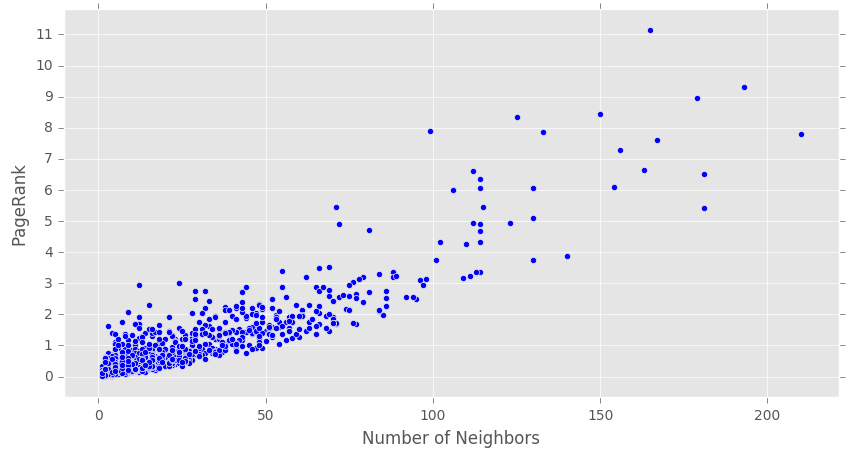

In [327]:
# Extract data from file
with open('pagerank_data.txt', 'rb') as fd:
    lines = fd.readlines()
    del fd

map_output = run_map(lines)
reduce_out = run_reduce(map_output)

x = map(lambda t: t[2], reduce_out)
y = map(lambda t: t[1], reduce_out)

plt.yticks(np.arange(0, max(y)+1, 1))
plt.xticks(np.arange(0, max(x)+30, 50))
plt.xlabel("Number of Neighbors")
plt.ylabel("PageRank")
plt.scatter(x,y)
plt.show()


All the above code only does one iteration or summation. The PageRanks get more precise with more iterations. Additionally, you can see that there is a positive linear relationship between the number of neighbors and the PageRank of the Node. You can also notice that this graph had many nodes with less than 50 neighbors. The outliers and variability in the nodes is a result of the damping factor. Try changing the value and see if the outliers still exist.

# Conclusion

MapReduce has a plethora of applications in distributed computing, NLP, and data science. If you enjoyed this tutorial, you may want to look into more into each application or more MapReduce libraries like [Hadoop](http://hadoop.apache.org/).